In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
from TargetDistributions.DoubleWell import QuadrupleWellEnergy
import torch
from FittedModels.utils.plotting_utils import plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.train import LearntDistributionManager
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils.plotting_utils import plot_history
import matplotlib.pyplot as plt
from FittedModels.utils.plotting_utils import plot_samples_vs_contours_quadruple_well

In [3]:
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples_vs_contours_quadruple_well(*args, **kwargs)
    plt.show()

In [4]:
target = QuadrupleWellEnergy(a=-0.5, b=-6)

# alpha=2 divergence

In [5]:
torch.manual_seed(1)
torch.set_default_dtype(torch.float64)
# ******************* Parameters *******************
dim = 4
epochs = int(2e4)
n_samples_estimation = int(1e5)
batch_size = int(1e3)
lr = 2e-5
train_prior = False
weight_decay = 1e-6
clip_grad_norm = False
optimizer = "Adam"
flow_type = "RealNVP"
loss_type = "DReG"
initial_flow_scaling = 1.5
n_flow_steps = 64
annealing = True
n_plots = 20

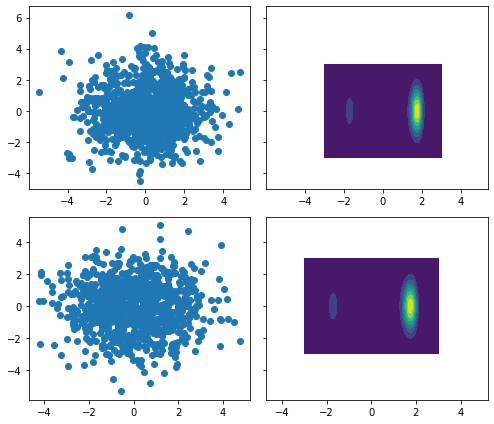

loss: -14.585680460769012, mean log p_x -6.022012919318888:   0%|          | 0/20000 [00:00<?, ?it/s]

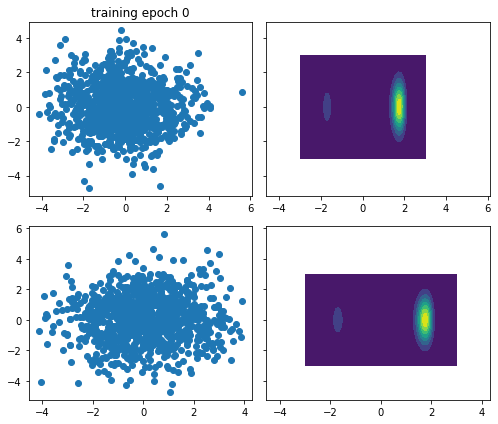

loss: -22.08813527370092, mean log p_x -5.698947883351485:   5%|▌         | 1000/20000 [04:23<1:21:47,  3.87it/s] 

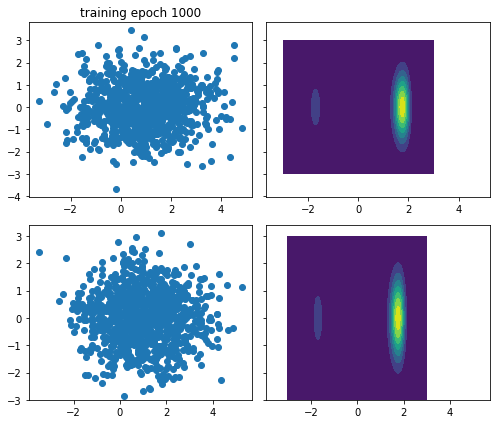

loss: -21.70169552989815, mean log p_x -10.237593832976208:   7%|▋         | 1319/20000 [05:46<1:22:34,  3.77it/s] 

In [ ]:
torch.manual_seed(0)  # 0
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps,
                           scaling_factor=initial_flow_scaling, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type=loss_type,
                                   lr=lr, optimizer=optimizer, annealing=annealing, weight_decay=weight_decay)

plotter(tester)
plt.show()
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

if train_prior:
    history_prior = tester.train_prior(epochs=200, batch_size=batch_size, lr=5e-3)
    plot_history(history_prior)
    plt.show()
    plotter(tester)
    plt.show()
    expectation_prior_trained, info_prior = tester.estimate_expectation(n_samples_estimation, expectation_function)


history = tester.train(epochs, batch_size=batch_size, clip_grad_norm=clip_grad_norm, max_grad_norm=1,
                       intermediate_plots=True, plotting_func=plotter, n_plots=n_plots)
plot_history(history)
plt.show()
plot_divergences(history)
plt.show()
plot_sampling_info(history)
plt.show()

expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

plotter(tester, n_samples=1000)
plt.show()